In [1]:
import pandas as pd
import os
import ast
import numpy as np
import math
from keras.optimizers import Adam
import random
from copy import deepcopy
%matplotlib inline
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import pickle
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist
import seaborn as sns
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import keras
from keras.layers import Dense, Dropout, LSTM, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Flatten, ZeroPadding1D, SimpleRNN, Bidirectional
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import json
from keras.models import model_from_json
from Bio import pairwise2
from Bio import SeqIO
from Bio.SubsMat import MatrixInfo as matlist

/Users/jacobwitten/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
CHARACTER_LIST = [u'A', u'C', u'E', u'D', u'G', u'F', u'I', u'H', u'K', u'M', u'L', u'N', u'Q', u'P', u'S', u'R', u'T', u'W', u'V', u'Y']
nchar = len(CHARACTER_LIST)
CHARACTER_LIST.sort()
CHARACTER_DICT = set([u'A', u'C', u'E', u'D', u'G', u'F', u'I', u'H', u'K', u'M', u'L', u'N', u'Q', u'P', u'S', u'R', u'T', u'W', u'V', u'Y'])
MAX_SEQUENCE_LENGTH=46
MAX_MIC = 4
FONT_TO_USE = 'Arial'

In [3]:
def generate_embedding(matrix_dict,min_corr=0.99):
    distance_matrix = np.zeros([len(CHARACTER_LIST),len(CHARACTER_LIST)])
    for i,char1 in enumerate(CHARACTER_LIST):
        for j,char2 in enumerate(CHARACTER_LIST):
            if (char1,char2) in matrix_dict.keys():
                distance_matrix[i,j] = (matrix_dict[(char1,char1)]+matrix_dict[(char2,char2)]-2*matrix_dict[(char1,char2)]+0.)
            else:
                distance_matrix[i,j] = (matrix_dict[(char1,char1)]+matrix_dict[(char2,char2)]-2*matrix_dict[(char2,char1)]+0.)
    G_matrix = np.zeros([nchar,nchar])
    for i in range(nchar):
        for j in range(nchar):
            G_matrix[i,i] += distance_matrix[i,j]**2/nchar
            for k in range(nchar):
                G_matrix[i,i] -= distance_matrix[j,k]**2/(2*(nchar**2))

    for i in range(nchar):
        for j in range(nchar):
            G_matrix[i,j] = (G_matrix[i,i]+G_matrix[j,j]-distance_matrix[i,j]**2)/2
    values,vectors = np.linalg.eigh(G_matrix)
    corr = 0
    n_dimensions = 0
    while corr<min_corr:
        n_dimensions += 1
        sqrt_lambda_matrix = np.zeros([n_dimensions,n_dimensions])
        for i in range(n_dimensions):
            sqrt_lambda_matrix[i,i] = np.sqrt(values[i-n_dimensions])
        u_matrix = vectors[:,nchar-n_dimensions:nchar]
        product = np.matmul(sqrt_lambda_matrix,np.transpose(u_matrix))
        embedding_matrix = np.zeros([n_dimensions,nchar])
        for i in range(nchar):
            for j in range(n_dimensions):
                embedding_matrix[j,i] = product[n_dimensions-1-j,i]
        embedding_matrix = np.transpose(embedding_matrix)
        reconst_dist_matrix = np.zeros([nchar,nchar])
        for i in range(nchar):
            for j in range(nchar):
                to_set = np.linalg.norm(embedding_matrix[i,:]-embedding_matrix[j,:])
                reconst_dist_matrix[i,j] = to_set
        old=[]
        reconst=[]
        for i in range(nchar-1):
            for j in range(i+1,nchar):
                old.append(distance_matrix[i,j])
                reconst.append(reconst_dist_matrix[i,j])
        corr = np.corrcoef(old,reconst)[0,1]
    embedding_dict = {}
    for i,char in enumerate(CHARACTER_LIST):
        embedding_dict[char] = embedding_matrix[i].tolist()
    return embedding_dict

In [6]:
# Each amino acid its own group
character_to_index = {
    (character): i
    for i, character in enumerate(CHARACTER_DICT)
}

index2character = {
    value: key
    for key, value in character_to_index.items()
}

# Generate the input vectors for our model
# Each vector is two dimensional
# The first dimension represents the number of characters in the sequence (46 characters)
# Each character is a vector of length equal to the number of groupings of amino acids
# This grouping can be 1-1 (each amino acid gets its own group), or coarser
def df_to_input_vec(df,shuffle = False,embed_dict=None):
    cterminal_amidation = np.array(df.has_cterminal_amidation)

    vectors = []
    for row in df.iterrows():
        vectors.append(row_to_vector(row[1],embed_dict=embed_dict, shuffle_sequence=shuffle))

    vectors = np.array(vectors)

    labels = np.array(df.value)
    sample_weights = np.full(len(labels), 1)
    return vectors, labels, sample_weights

def generate_random_sequence(alphabet, length_of_sequence_min=0, length_of_sequence_max=MAX_SEQUENCE_LENGTH, include_C = True):
        sequence = ''
        choices = [char for char in alphabet if (include_C or char !='C')]
        counter = 0
        length_to_use = -10
        while counter<20 and (length_to_use < length_of_sequence_min or length_to_use > length_of_sequence_max):
            length_to_use = random.choice(SEQ_LENGTHS)
            counter += 1
        for _ in range(length_to_use):
            sequence += random.choice(choices)
        has_cterminal_amidation = random.uniform(0, 1)

        return {
            'sequence': sequence,
            'has_cterminal_amidation': has_cterminal_amidation>0.5
#             Used to be 0.5 but only 34% of positive data has amidation OOPS
        }

def add_random_negative_examples(vectors, labels, sample_weights, ratio, max_mic = None, include_cysteine = True):
    if not max_mic:
        max_mic = max(labels)
    # We will add randomly chosen sequences as negative examples
    # We will double the length of our training set

    len_vectors = ratio * len(vectors)
    negative_rows = []
    for i in range(len_vectors):
        negative_rows.append(row_to_vector(generate_random_sequence(list(CHARACTER_DICT),include_C = include_cysteine)))
    negative_vectors = np.array(negative_rows)
    vectors = np.concatenate((vectors, negative_vectors))
    negative_labels = np.full(len_vectors, max_mic)
    labels = np.concatenate((labels, negative_labels))
    # Weight all samples equally
    sample_weights = np.concatenate((sample_weights, np.full(len_vectors, 1)))
    return vectors, labels, sample_weights

def generate_train_test_splits(
        vectors, labels,
        extra_training_vectors=[], extra_training_labels=[], extra_sample_weights=[],
        cutoff=0.85
):
    cutoff = int(cutoff * len(labels))
    idx = range(len(vectors))
    random.shuffle(idx)
    reordered_vectors = vectors[idx]
    reordered_labels = labels[idx]
    reordered_sample_weights = sample_weights[idx]
    if len(extra_training_vectors) > 0:
        train_x = np.concatenate((reordered_vectors[:cutoff], extra_training_vectors))
        train_y = np.concatenate((reordered_labels[:cutoff], extra_training_labels))
        train_sample_weights = np.concatenate((reordered_sample_weights[:cutoff], pa_sample_weights))
    else:
        train_x = reordered_vectors[:cutoff]
        train_y = reordered_labels[:cutoff]
        train_sample_weights = reordered_sample_weights[:cutoff]
    test_x = reordered_vectors[cutoff:]
    test_y = reordered_labels[cutoff:]
    return train_x, train_y, test_x, test_y, train_sample_weights

# Convolutional NN
def conv_model(embed_length = (len(character_to_index)+1),kernelsize = 5):
    model = keras.models.Sequential()
    model.add(ZeroPadding1D(
        kernelsize, input_shape = (MAX_SEQUENCE_LENGTH, embed_length)
    ))
    model.add(Conv1D(
        64,
        kernel_size = kernelsize,
        strides = 1,
        activation = 'relu',
        #input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    #model.add(Dropout(0.5))
    model.add(Conv1D(64, kernelsize, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Convolutional NN
def conv_model_set_dropout(dropout_level=0.5,embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
    model.add(ZeroPadding1D(
        5, input_shape = (MAX_SEQUENCE_LENGTH, embed_length)
    ))
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        #input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    #model.add(Dropout(0.5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(dropout_level))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Convolutional NN
def conv_model_move_dropout(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
    model.add(ZeroPadding1D(
        5, input_shape = (MAX_SEQUENCE_LENGTH, embed_length)
    ))
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        #input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    #model.add(Dropout(0.5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Convolutional NN
def one_layer_conv_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
    model.add(ZeroPadding1D(
        5, input_shape = (MAX_SEQUENCE_LENGTH, embed_length)
    ))
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        #input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def lstm_model(embed_length = (len(character_to_index)+1),learn_rate=None):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(LSTM(
        64,
        input_shape=(MAX_SEQUENCE_LENGTH, embed_length),
    ))
#     model.add(Flatten())
    model.add(Dropout(0.5))
#     model.add(Dense(100, kernel_initializer='normal'))
# #     model.add(Dropout(0.5))
#     model.add(Dense(20, kernel_initializer='normal'))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
#     model.add(Dense(1, kernel_initializer='normal'))
    if learn_rate is None:
        model.compile(loss='mean_squared_error', optimizer='adam')
    else:
        model.compile(loss='mean_squared_error',optimizer=Adam(lr=learn_rate))
    return model

def two_layer_recurrent_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(SimpleRNN(
        64,
        input_shape=(MAX_SEQUENCE_LENGTH, embed_length),return_sequences=True
    ))
    model.add(SimpleRNN(64))
#     model.add(Flatten())
    model.add(Dropout(0.5))
#     model.add(Dense(100, kernel_initializer='normal'))
#     model.add(Dense(20, kernel_initializer='normal'))
#     model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def three_layer_recurrent_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(SimpleRNN(
        64,
        input_shape=(MAX_SEQUENCE_LENGTH, embed_length),return_sequences=True
    ))
    model.add(SimpleRNN(64,return_sequences=True))
    model.add(SimpleRNN(64))
#     model.add(Flatten())
    model.add(Dropout(0.5))
#     model.add(Dense(100, kernel_initializer='normal'))
#     model.add(Dense(20, kernel_initializer='normal'))
#     model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def one_layer_recurrent_model(embed_length = (len(character_to_index)+1), learn_rate = None):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(SimpleRNN(
        64,
        input_shape=(MAX_SEQUENCE_LENGTH, embed_length),return_sequences=False
    ))
#     model.add(Flatten())
    model.add(Dropout(0.5))
#     model.add(Dense(100, kernel_initializer='normal'))
#     model.add(Dense(20, kernel_initializer='normal'))
#     model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    if learn_rate is None:
        model.compile(loss='mean_squared_error',optimizer='adam')
    else:
        model.compile(loss='mean_squared_error', optimizer=Adam(lr=learn_rate))
    return model

def bilstm_model(embed_length = (len(character_to_index)+1)):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(Bidirectional(LSTM(
        64
    ),input_shape=(MAX_SEQUENCE_LENGTH, embed_length)))
#     model.add(Flatten())
    model.add(Dropout(0.5))
#     model.add(Dense(100, kernel_initializer='normal'))
# #     model.add(Dropout(0.5))
#     model.add(Dense(20, kernel_initializer='normal'))
#     model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def birecurrent_model(embed_length = (len(character_to_index)+1),learn_rate=None):
    model = keras.models.Sequential()
#     model = keras.models.Sequential()
    model.add(Bidirectional(SimpleRNN(
        64,return_sequences=False
    ),input_shape=(MAX_SEQUENCE_LENGTH, embed_length)))
#     model.add(Flatten())
    model.add(Dropout(0.5))
#     model.add(Dense(100, kernel_initializer='normal'))
#     model.add(Dense(20, kernel_initializer='normal'))
#     model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    if learn_rate is None:
        model.compile(loss='mean_squared_error', optimizer='adam')
    else:
        model.compile(loss='mean_squared_error',optimizer=Adam(lr=learn_rate))
    return model

class EnsembleModel:
    def __init__(self,models,predict_method,max_mic_buffer=0.1):
        self.models = models
        self.predict_method = predict_method
        self.max_mic_buffer = max_mic_buffer
        
    def combine_predictions(self,predictions):
        if self.predict_method is 'average':
            return np.mean(predictions)
        elif self.predict_method is 'classify_then_average':
            actual_predictions = []
            for prediction in predictions:
                if prediction < MAX_MIC - self.max_mic_buffer:
                    actual_predictions.append(prediction)
            if float(len(actual_predictions))/float(len(predictions))>=0.49:
                return np.mean(predictions)
            else:
                return MAX_MIC
        else:
            print 'predict_method not recognized'
            return -100
        
    def predict(self,test_x):
        all_predictions = []
        combined_predictions = []
        for model in self.models:
            all_predictions.append(model.predict(test_x))
        for i in range(len(test_x)):
            combined_predictions.append(self.combine_predictions([all_predictions[k][i] for k in range(len(self.models))]))
        return combined_predictions
    
    def evaluate(self,test_x,test_y):
        predictions = self.predict(test_x)
        correctly_classified_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions) if actual < MAX_MIC and predicted < MAX_MIC - self.max_mic_buffer])    
        all_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions)])    
        all_active_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions) if actual < MAX_MIC])    
        return correctly_classified_error,all_active_error, all_error
    
    def evaluate_as_classifier(self,test_x,test_y):
        true_positives=0
        true_negatives=0
        false_positives=0
        false_negatives=0
        all_predicted=self.predict(test_x)
        for i in range(len(test_y)):
            actual=test_y[i]
            predicted=all_predicted[i]
            if actual<MAX_MIC-0.0001:
                if predicted<MAX_MIC - self.max_mic_buffer:
                    true_positives+=1
                else:
                    false_negatives+=1
            else:
                if predicted<MAX_MIC - self.max_mic_buffer:
                    false_positives += 1
        #             print vector_to_amp(test_x[i])
        #             print 'predicted: '+repr(predicted)+', actual: '+repr(actual)
#                     print '>p'+repr(false_positives)+'_'+repr(predicted)
#                     print vector_to_amp(test_x[i])['sequence'].replace('_','')
                else:
                    true_negatives += 1
        return true_positives,true_negatives,false_positives,false_negatives
        
                                             

In [7]:
# Enter an element of a result dictionary into df-ready row
# Standardize units of MIC
def standardize_to_uM(concentration, unit, sequence):
    concentration = concentration.replace(' ', '')
    try:
        concentration = float(concentration)
    except:
        return None
    if unit == 'uM' or unit == u'\xb5M' or unit == u'uM)':
        return concentration
    elif unit == 'ug/ml' or unit == u'\xb5g/ml' or unit == u'ug/ml)':
        try:
            molWt = ProteinAnalysis(sequence).molecular_weight()
        except ValueError:
            return None
        return concentration * 1000/molWt
    elif unit == 'nmol/g' or unit == 'pmol/mg':
        #1g, at density of 1g/mL, is 1mL, so nmol/g is nmol/mL = umol/L = uM yay!
        return concentration
    else:
        # print 'Unit not recognized: ' + unit
        return None
    
def convert_result_to_rows(sequence, result):
    rows = []
    if 'bacteria' not in result:
        return rows
    for bacterium, strain in result['bacteria']:
        
        rows.append({
            'bacterium': bacterium,
            'strain': strain,
            'sequence': sequence.upper(),
            'url_source': result['url_sources'][0],
            'value': standardize_to_uM(
                result['bacteria'][(bacterium, strain)]['value'],
                result['bacteria'][(bacterium, strain)]['unit'],
                sequence
            ),
            'modifications': result['modifications'] if 'modifications' in result else [],
            'unit': 'uM'
        })
        if rows[-1]['value']:
            rows[-1]['value'] = np.log10(rows[-1]['value'])
    return rows

# Remove sequences with amino acids that aren't well-defined
def strip_sequences_with_char(df, bad_char):
    return df[~df.sequence.str.contains(bad_char)]

# We'll want to strip off any sequences with modifications that could be hard to replicate
# Their effects are too complex for the model
def is_modified(modifications_list):
    return len(modifications_list) > 0

# However, C-Terminal Amidation is common enough that we make an exception
CTERM_AMIDATION_TERMS = ['C-Terminal amidation','C-Terminus: AMD','C-Terminal','C-termianal amidation']

def has_non_cterminal_modification(modifications_list):
    return any(['C-Term' not in modification for modification in modifications_list])

def has_unusual_modification(modifications_list):
    return any([is_uncommon_modification(mod) for mod in modifications_list])

def has_cterminal_amidation(modifications_list):
    return any([is_cterminal_amidation(mod) for mod in modifications_list])

def has_disulfide_bonds(modifications_list):
    return any([is_disulfide_bond(mod) for mod in modifications_list])

def is_cterminal_amidation(mod):
    for term in CTERM_AMIDATION_TERMS:
        if term in mod:
            return True
    return False

def is_disulfide_bond(mod):
    return 'disulfide' in mod.lower()

def is_uncommon_modification(mod):
    return (not is_cterminal_amidation(mod)) and (not is_disulfide_bond(mod))

def datasource_has_modifications(cell):
    # Everything except CAMP and YADAMP has modification data
    return not any([s in cell for s in no_modification_data_sources])

def sequence_has_modification_data(cell):
    # If the sequence is labeled modifictationless in another database it's OK
    return cell in sequences_containing_modifications

def sequence_to_vector(sequence, cterminal_amidation,embed_dict=None):
# It looks like this truncates any sequence after max_sequence_length (which is length of 95th percentile longest peptide)
# I just add cterminal amidation as the amino acid after the last real amino acid (if the amino acid gets truncated
# then the cterminal amidation also gets cut off)
    if embed_dict==None:
        default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])
        for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
            default[i][character_to_index[character]] = 1
        if len(sequence)<MAX_SEQUENCE_LENGTH:
            default[len(sequence)][-1]=cterminal_amidation
    else:
        default = np.zeros([MAX_SEQUENCE_LENGTH,len(embed_dict['A'])+1])
        for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
            embedding = deepcopy(embed_dict[character])
            embedding.append(0)
            for k,val in enumerate(embedding):
                default[i,k] = val
            if len(sequence)<MAX_SEQUENCE_LENGTH:
                for i in range(len(sequence),MAX_SEQUENCE_LENGTH):
                    default[i,-1]=1
    return default

def find_character(character2index, character):
    for key in character2index:
        if character in key:
            return character2index[key]
    return -2

def row_to_vector(row, embed_dict=None,shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_amidation']
    return sequence_to_vector(sequence,cterminal_amidation,embed_dict=embed_dict)

def old_row_to_vector(row, shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_amidation']
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])

    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][find_character(character_to_index, character)] = 1
        default[i][-1] = cterminal_amidation

    return default

def vector_to_amp(vector):
    sequence = ''
    has_cterm = False
    for v in vector:
        nonzeros = np.argwhere(v[:len(character_to_index)])
        if len(nonzeros) > 1:
            print("?????")
        elif len(nonzeros) == 0:
            sequence += '_'
        else:
            sequence += index2character[np.argwhere(v)[0][0]]  # First one
        if v[-1]>0:
            has_cterm=True
    return {
        'sequence': sequence,
        'cterminal_amidation': has_cterm
    }

def bacterium_to_sample_weight(bacterium, intended_bacterium='E. coli'):
    if intended_bacterium in bacterium:
        return 1
    else:
        return 0.5
    
def containing_bacterium(bacterium, df):
    return df.loc[df.bacterium.str.contains(bacterium)]

def average_over_databases(bacterium_df):
    return bacterium_df.groupby('sequence')['value'].mean().dropna()

def get_bacterium_df(bacterium, df):
    bdf = df.loc[(df.bacterium.str.contains(bacterium))].groupby(['sequence', 'bacterium'])
    return bdf.mean().reset_index().dropna()

def strip_bad_amino_acids(df, bad_amino_acids=('U', 'X', 'Z')):
    for b in bad_amino_acids:
        df = df.loc[~df.sequence.str.contains(b)]
    return df.reset_index()

def split_dataframe(df_to_split,cutoff=0.85):
    train_indices = []
    test_indices = []
    for i in range(len(df_to_split)):
        if 'C' not in df_to_split['sequence'][i] and random.random()>cutoff:
            test_indices.append(i)
        else:
            train_indices.append(i)
    train_df = df_to_split.iloc[train_indices]
    test_df = df_to_split.iloc[test_indices]
    return train_df, test_df

In [8]:
ecoli_train_with_c = pd.read_pickle('Saved_variables/ecoli_train_with_c_df.pkl')
ecoli_train_no_c = pd.read_pickle('Saved_variables/ecoli_train_no_c_df.pkl')
ecoli_test = pd.read_pickle('Saved_variables/ecoli_test_df.pkl')
ecoli_df = pd.read_pickle('Saved_variables/ecoli_all_df.pkl')
ecoli_df_no_c = pd.read_pickle('Saved_variables/ecoli_all_no_c_df.pkl')
all_df = pd.read_pickle('Saved_variables/all_df.pkl')
ecoli_train_train_no_c = pd.read_pickle('Saved_variables/ecoli_train_train_no_c_df.pkl')
ecoli_validate_no_c = pd.read_pickle('Saved_variables/ecoli_validate_no_c_df.pkl')

In [81]:
#Generating the train-test split (only do this once)
# ecoli_train_train_no_c, ecoli_validate_no_c = train_test_split(ecoli_train_no_c,test_size=0.2)
# ecoli_train_train_no_c.to_pickle('Saved_variables/ecoli_train_train_no_c_df.pkl')
# ecoli_validate_no_c.to_pickle('Saved_variables/ecoli_validate_no_c_df.pkl')

In [8]:
b62_embedding = generate_embedding(matlist.blosum62,0.997)

In [100]:
ecoli_train_input_embed = df_to_input_vec(ecoli_train_no_c,embed_dict=b62_embedding)
ecoli_test_one_hot = df_to_input_vec(ecoli_test)
ecoli_train_input_one_hot = df_to_input_vec(ecoli_train_no_c)
ecoli_train_input_one_hot_ridge = [vec.flatten() for vec in ecoli_train_input_one_hot[0]]

# Generating test and training sets (different featurizations for different ML approaches)

In [244]:
ecoli_train_no_c = ecoli_train_no_c.reset_index(drop=True)
ecoli_test = ecoli_test.reset_index(drop=True)
train_x_aa_counts = []
train_x_seqs = []
train_x = []
train_y = []
train_x_ridge=[]
test_x = []
test_x_seqs = []
test_x_aa_counts = []
test_y = []
test_x_ridge=[]
lengths_1=[]
lengths_2=[]
for i in range(len(ecoli_train_no_c)):
    lengths_1.append(len(ecoli_train_no_c.sequence[i]))
    if True:#len(ecoli_train_no_c.sequence[i])<MAX_SEQUENCE_LENGTH:
        train_x_seqs.append(ecoli_train_no_c.sequence[i])
        train_x_aa_counts.append(sequence_to_aa_counts(ecoli_train_no_c.sequence[i],ecoli_train_no_c.has_cterminal_amidation[i])) 
        train_y.append(ecoli_train_no_c.value[i])
        train_x.append(sequence_to_vector(ecoli_train_no_c.sequence[i],ecoli_train_no_c.has_cterminal_amidation[i]))
        train_x_ridge.append(sequence_to_vector(ecoli_train_no_c.sequence[i],ecoli_train_no_c.has_cterminal_amidation[i]).flatten())
        lengths_2.append(len(ecoli_train_no_c.sequence[i]))
for i in range(len(ecoli_test)):
    if len(ecoli_test.sequence[i])<MAX_SEQUENCE_LENGTH:
        test_x_seqs.append(ecoli_test.sequence[i])
        test_x_aa_counts.append(sequence_to_aa_counts(ecoli_test.sequence[i],ecoli_test.has_cterminal_amidation[i])) 
        test_y.append(ecoli_test.value[i])
        test_x.append(sequence_to_vector(ecoli_test.sequence[i],ecoli_test.has_cterminal_amidation[i]))
        test_x_ridge.append(sequence_to_vector(ecoli_test.sequence[i],ecoli_test.has_cterminal_amidation[i]).flatten())
        
train_x = np.array(train_x)
test_x = np.array(test_x)
test_y = np.array(test_y)
train_y = np.array(train_y)

# Ridge regression

## Ridge regression on the whole 21x46 variables

In [246]:
alphas_to_test = [0.0001,0.001,0.01,0.1,1,10,100,1000]
ridge_train_one_hot = RidgeCV(alphas=alphas_to_test)
ridge_train_one_hot.fit(train_x_ridge,train_y)
print ridge_train_one_hot.alpha_

10.0


In [247]:
alphas_to_test = [0.0001,2,4,8,16,24,26,27,28,29,30,31,32,36,40,64]
ridge_train_one_hot = RidgeCV(alphas=alphas_to_test)
ridge_train_one_hot.fit(train_x_ridge,train_y)
print ridge_train_one_hot.alpha_

29.0


In [248]:
ridge_predicted = ridge_train_one_hot.predict(test_x_ridge)

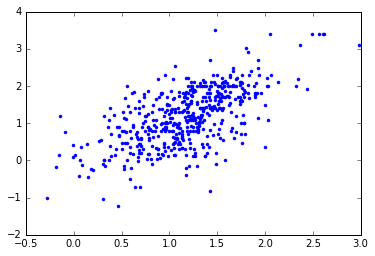

0.6274677663943323
0.43187093180416586
MSE: 0.36338475921572205


In [249]:
plt.plot(ridge_predicted,test_y,'.')
plt.show()
print np.corrcoef(ridge_predicted,test_y)[0,1]
tau,pval = kendalltau(ridge_predicted,test_y)
print tau
print 'MSE: '+repr(float(np.average([(ridge_predicted[i]-test_y[i])**2 for i in range(len(test_y))])))

## Ridge regression using just the amino acid counts

In [250]:
def sequence_to_aa_counts(sequence,cterm_amidation):
    to_return = []
    for char in CHARACTER_LIST:
        to_return.append(sequence.count(char))
    if cterm_amidation>0.5:
        to_return.append(1)
    else:
        to_return.append(0)
    return to_return

In [251]:
alphas_to_test = [0.0001,0.001,0.01,0.1,1,10,100,1000]
ridge_train_counts = RidgeCV(alphas=alphas_to_test)
ridge_train_counts.fit(train_x_aa_counts,train_y)
print ridge_train_counts.alpha_

100.0


In [252]:
alphas_to_test = [0.0001,100,120,140,150,160,165,167,170,171,172,173,174,175,180,200,320,640]
ridge_train_counts = RidgeCV(alphas=alphas_to_test)
ridge_train_counts.fit(train_x_aa_counts,train_y)
print ridge_train_counts.alpha_

172.0


In [253]:
ridge_predicted_counts = ridge_train_counts.predict(test_x_aa_counts)

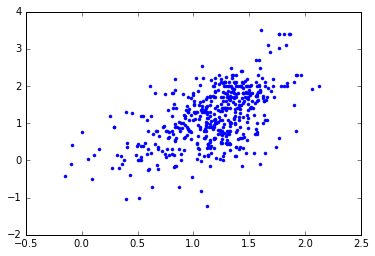

In [254]:
plt.plot(ridge_predicted_counts,test_y,'.')
plt.show()

In [255]:
print 'Pearson corr: '+repr(np.corrcoef(ridge_predicted_counts,test_y)[0,1])
tau,pval = kendalltau(ridge_predicted_counts,test_y)
print 'Kendall tau: '+repr(tau)
print 'MSE: '+repr(float(np.average([(ridge_predicted_counts[i]-test_y[i])**2 for i in range(len(test_y))])))

Pearson corr: 0.5601172810273505
Kendall tau: 0.3794419789437846
MSE: 0.41544297774414196


## Neural network analysis and comparisons; note default learning rate is 0.001

In [256]:
conv_model_normal = conv_model()
conv_model_normal.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_kernel4 = conv_model(kernelsize=4)
# conv_model_kernel4.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_kernel6 = conv_model(kernelsize=6)
# conv_model_kernel6.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_kernel3 = conv_model(kernelsize=3)
# conv_model_kernel3.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_kernel2 = conv_model(kernelsize=2)
# conv_model_kernel2.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_kernel7 = conv_model(kernelsize=7)
# conv_model_kernel7.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_kernel1 = conv_model(kernelsize=1)
# conv_model_kernel1.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_one_layer = one_layer_conv_model()
# conv_model_one_layer.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_moved_dropout = conv_model_move_dropout()
# conv_model_moved_dropout.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_p9_dropout = conv_model_set_dropout(dropout_level=0.9)
# conv_model_p9_dropout.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_p7_dropout = conv_model_set_dropout(dropout_level=0.7)
# conv_model_p7_dropout.fit(train_x,train_y,batch_size=40,epochs=100)

# conv_model_p3_dropout = conv_model_set_dropout(dropout_level=0.3)
# conv_model_p3_dropout.fit(train_x,train_y,batch_size=40,epochs=100)

# rnn_one_layer = one_layer_recurrent_model()
# rnn_one_layer.fit(train_x,train_y,batch_size=40,epochs=100)

# rnn_two_layers = two_layer_recurrent_model()
# rnn_two_layers.fit(train_x,train_y,batch_size=40,epochs=100)

# rnn_three_layers = three_layer_recurrent_model()
# rnn_three_layers.fit(train_x,train_y,batch_size=40,epochs=100)

# lstm_mod = lstm_model()
# lstm_mod.fit(train_x,train_y,batch_size=40,epochs=100)

# bi_rnn = birecurrent_model()
# bi_rnn.fit(train_x,train_y,batch_size=40,epochs=100)

# bi_lstm = bilstm_model()
# bi_lstm.fit(train_x,train_y,batch_size=40,epochs=100)

# bi_rnn_p01 = birecurrent_model(learn_rate=0.01)
# bi_rnn_p01.fit(train_x,train_y,batch_size=40,epochs=100)

# bi_rnn_p1 = birecurrent_model(learn_rate=0.1)
# bi_rnn_p1.fit(train_x,train_y,batch_size=40,epochs=100)

# bi_rnn_p0001 = birecurrent_model(learn_rate=0.0001)
# bi_rnn_p0001.fit(train_x,train_y,batch_size=40,epochs=100)

# bi_rnn_p00001 = birecurrent_model(learn_rate=0.00001)
# bi_rnn_p00001.fit(train_x,train_y,batch_size=40,epochs=100)

# lstm_p01 = lstm_model(learn_rate=0.01)
# lstm_p01.fit(train_x,train_y,batch_size=40,epochs=100)

# lstm_p1 = lstm_model(learn_rate=0.1)
# lstm_p1.fit(train_x,train_y,batch_size=40,epochs=100)

# lstm_p05 = lstm_model(learn_rate=0.05)
# lstm_p05.fit(train_x,train_y,batch_size=40,epochs=100)

# lstm_p02 = lstm_model(learn_rate=0.02)
# lstm_p02.fit(train_x,train_y,batch_size=40,epochs=100)

# lstm_p0001 = lstm_model(learn_rate=0.0001)
# lstm_p0001.fit(train_x,train_y,batch_size=40,epochs=100)

# lstm_p00001 = lstm_model(learn_rate=0.00001)
# lstm_p00001.fit(train_x,train_y,batch_size=40,epochs=100)

# bi_lstm_300 = bilstm_model()
# bi_lstm_300.fit(train_x,train_y,batch_size=40,epochs=300)

Epoch 1/100
2895/2895 [==============================] - 9s 3ms/step - loss: 0.6607
Epoch 2/100
2895/2895 [==============================] - 1s 462us/step - loss: 0.4172
Epoch 3/100
2895/2895 [==============================] - 1s 494us/step - loss: 0.3710
Epoch 4/100
2895/2895 [==============================] - 1s 495us/step - loss: 0.3271
Epoch 5/100
2895/2895 [==============================] - 1s 478us/step - loss: 0.3004
Epoch 6/100
2895/2895 [==============================] - 1s 491us/step - loss: 0.2835
Epoch 7/100
2895/2895 [==============================] - 1s 454us/step - loss: 0.2547
Epoch 8/100
2895/2895 [==============================] - 1s 425us/step - loss: 0.2287
Epoch 9/100
2895/2895 [==============================] - 1s 376us/step - loss: 0.2244
Epoch 10/100
2895/2895 [==============================] - 1s 382us/step - loss: 0.2135
Epoch 11/100
2895/2895 [==============================] - 1s 385us/step - loss: 0.1946
Epoch 12/100
2895/2895 [==============================

In [231]:
def evaluate_model(model):
    predicted = model.predict(test_x)
    predicted = [pred[0] for pred in predicted]
#     plt.plot(predicted,test_y,'.')
#     plt.show()
    to_return = 'RMSE,'+repr(np.sqrt(float(np.average([(predicted[i]-test_y[i])**2 for i in range(len(test_y))]))))
    to_return += ',Pearson Correlation,'+repr(float(np.corrcoef(predicted,test_y)[1,0]))
    tau,pval = kendalltau(predicted,test_y)
    to_return += ',Kendall tau Correlation,'+repr(tau)
    to_return += ',MSE,'+repr(float(np.average([(predicted[i]-test_y[i])**2 for i in range(len(test_y))])))
    print to_return
    return to_return

In [257]:
evaluate_model(conv_model_normal)
# evaluate_model(conv_model_kernel1)
# evaluate_model(conv_model_kernel2)
# evaluate_model(conv_model_kernel3)
# evaluate_model(conv_model_kernel4)
# evaluate_model(conv_model_kernel6)
# evaluate_model(conv_model_kernel7)
# evaluate_model(conv_model_one_layer)
# evaluate_model(conv_model_moved_dropout)
# evaluate_model(conv_model_p9_dropout)
# evaluate_model(conv_model_p7_dropout)
# evaluate_model(conv_model_p3_dropout)
# evaluate_model(rnn_one_layer)
# evaluate_model(rnn_two_layers)
# evaluate_model(rnn_three_layers)
# evaluate_model(bi_rnn)
# evaluate_model(lstm_p00001)
# evaluate_model(lstm_p0001)
# evaluate_model(lstm_mod)
# evaluate_model(lstm_p01)
# evaluate_model(lstm_p1)
# evaluate_model(bi_lstm)
# evaluate_model(lstm_p02)
# evaluate_model(lstm_p05)
# evaluate_model(bi_rnn_p01)
# evaluate_model(bi_rnn_p1)
# evaluate_model(bi_rnn_p0001)
# evaluate_model(bi_rnn_p00001)
# evaluate_model(bi_lstm_300)

RMSE,0.5017459404365912,Pearson Correlation,0.7700296338278537,Kendall tau Correlation,0.5705882658527176,MSE,0.2517489887445993


'RMSE,0.5017459404365912,Pearson Correlation,0.7700296338278537,Kendall tau Correlation,0.5705882658527176,MSE,0.2517489887445993'

# kNN regression

In [258]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

class kNN_model:
    def __init__(self,seq_db,mic_vals,k,local=True,score_matrix=matlist.ident,gap_open_penalty=-9,gap_extension_penalty=-1,edit_distance=False):
        self.seq_db = seq_db
        self.k = k
        self.mic_vals = mic_vals
        self.local = local
        self.score_matrix = score_matrix
        self.gap_open_penalty = gap_open_penalty
        self.gap_extension_penalty = gap_extension_penalty
        self.edit_distance = edit_distance
    def predict_knn(self,seq):
        alignment_scores = [0]*len(self.seq_db)
        for i in range(len(self.seq_db)):
            sequence = self.seq_db[i]
            if self.edit_distance:
                alignment_scores[i] = -1*levenshtein(seq,sequence)
            elif self.local:
                alignment_scores[i] = pairwise2.align.localds(seq,sequence,self.score_matrix,self.gap_open_penalty,self.gap_extension_penalty,score_only=True)
            else:
                alignment_scores[i] = pairwise2.align.globalds(seq,sequence,self.score_matrix,self.gap_open_penalty,self.gap_extension_penalty,score_only=True)
        indices = np.argpartition(alignment_scores,-1*self.k)[(-1*self.k):]
        guess=0
        for index in indices:
            guess += float(self.mic_vals[index])
        return guess/self.k
    def prediction_with_similarity(self,seq):
        alignment_scores = [0]*len(self.seq_db)
        for i in range(len(self.seq_db)):
            sequence = self.seq_db[i]
            if self.edit_distance:
                alignment_scores[i] = -1*levenshtein(seq,sequence)
            elif self.local:
                alignment_scores[i] = pairwise2.align.localds(seq,sequence,self.score_matrix,self.gap_open_penalty,self.gap_extension_penalty,score_only=True)
            else:
                alignment_scores[i] = pairwise2.align.globalds(seq,sequence,self.score_matrix,self.gap_open_penalty,self.gap_extension_penalty,score_only=True)
        indices = np.argpartition(alignment_scores,-1*self.k)[(-1*self.k):]
        max_align_score = max(alignment_scores)
        guess=0
        for index in indices:
            guess += float(self.mic_vals[index])
        return max_align_score,guess/self.k
    def error_vs_align_score(self,seqs,test_mics):
        scores = []
        sqrt_errors = []
        for i,seq in enumerate(seqs):
            align_score,prediction = self.prediction_with_similarity(seq)
            scores.append(align_score)
            sqrt_errors.append(np.sqrt((prediction-test_mics[i])**2))
        return scores,sqrt_errors     
    def predict(self,seqs):
        return [self.predict_knn(seq) for seq in seqs]

In [259]:
def evaluate_knn_model(knn_model):
    predicted = knn_model.predict(test_x_seqs)
#     predicted = [pred[0] for pred in predicted]
#     plt.plot(predicted,test_y,'.')
#     plt.show()
#     print 'MSE: '+repr(float(np.average([(predicted[i]-test_y[i])**2 for i in range(len(test_y))])))
#     print 'Pearson Correlation: '+repr(float(np.corrcoef(predicted,test_y)[1,0]))
    tau,pval = kendalltau(predicted,test_y)
#     print 'Kendall tau Correlation: '+repr(tau)
    mse = 'MSE,'+repr(float(np.average([(predicted[i]-test_y[i])**2 for i in range(len(test_y))])))
    pearson = 'Pearson,'+repr(float(np.corrcoef(predicted,test_y)[1,0]))
    tau = 'Kendall tau,'+repr(tau)
    return mse+','+pearson+','+tau+','

In [260]:
# Using the best model based on validation set
knn_model = kNN_model(train_x_seqs,train_y,5,edit_distance=True)
print 'k,5,Edit distance,n/a,'+evaluate_knn_model(knn_model) 

k,5,Edit distance,n/a,MSE,0.2957386359801885,Pearson,0.7160638862911988,Kendall tau,0.5042597322796677,


In [241]:
for k in range(7,9):
    knn_model = kNN_model(train_x_seqs,train_y,k,edit_distance=True)
    print 'k,'+repr(k)+',Edit distance,n/a,'+evaluate_knn_model(knn_model)
    knn_model = kNN_model(train_x_seqs,train_y,k,score_matrix=matlist.pam30)
    print 'k,'+repr(k)+',Local,Pam30,'+evaluate_knn_model(knn_model)
    knn_model = kNN_model(train_x_seqs,train_y,k,local=False,score_matrix=matlist.pam30)
    print 'k,'+repr(k)+',Global,Pam30,'+evaluate_knn_model(knn_model)
    knn_model = kNN_model(train_x_seqs,train_y,k)
    print 'k,'+repr(k)+',Local,Identity,'+evaluate_knn_model(knn_model)
    knn_model = kNN_model(train_x_seqs,train_y,k,local=False)
    print 'k,'+repr(k)+',Global,Identity,'+evaluate_knn_model(knn_model)

k,7,Edit distance,n/a,MSE,0.3274507158382785,Pearson,0.6809477603880043,Kendall tau,0.46321277683261175,
k,7,Local,Pam30,MSE,0.4526885352717089,Pearson,0.5633828028223556,Kendall tau,0.36606249247518946,
k,7,Global,Pam30,MSE,0.3806242975015145,Pearson,0.6264822905994067,Kendall tau,0.40547849088342036,
k,7,Local,Identity,MSE,0.4383547597628035,Pearson,0.5827605124519708,Kendall tau,0.37579977635356787,
k,7,Global,Identity,MSE,0.36692862058403447,Pearson,0.6423241268828116,Kendall tau,0.42125075354140473,
k,8,Edit distance,n/a,MSE,0.3340565313305525,Pearson,0.6731233730264672,Kendall tau,0.459712301164396,
k,8,Local,Pam30,MSE,0.4455778075656142,Pearson,0.5712035153263394,Kendall tau,0.36638180524951564,
k,8,Global,Pam30,MSE,0.38298487393425007,Pearson,0.6225764746295971,Kendall tau,0.4040353159282329,
k,8,Local,Identity,MSE,0.44224383420287583,Pearson,0.5750572594388242,Kendall tau,0.366543694729149,
k,8,Global,Identity,MSE,0.3692584254390431,Pearson,0.6388163958967668,Kendall tau,0.417